<a href="https://colab.research.google.com/github/Faisal-NSU/CSE465/blob/main/Subesco%20Training%20(Must%20use%20Skeleton).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unzip Dataset (Subesco)

# Download And Extract

In [1]:
#Subesco.zip
!gdown --id 1k-afEJdwz5Tf4-bsuKOJzP7xn-KQTlkM

Downloading...
From: https://drive.google.com/uc?id=1k-afEJdwz5Tf4-bsuKOJzP7xn-KQTlkM
To: /content/SUBESCO.zip
100% 1.65G/1.65G [00:18<00:00, 89.0MB/s]


In [2]:
import zipfile
dataset_directory = '/content/SUBESCO.zip'
zip_ref = zipfile.ZipFile(dataset_directory, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Custom Dataset Class

Create custom Dataset

In [46]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn.functional import normalize


class CustomDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        #print(audio_sample_path)
        label = self._get_audio_sample_label(index)
        #print(label)
        #signal, sr = torchaudio.load(audio_sample_path,frame_offset=int(self.num_samples*.3),num_frames = self.target_sample_rate)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        # produce delta and delta-delta and add to mfcc
        delta = torchaudio.functional.compute_deltas(signal)
        delta2 = torchaudio.functional.compute_deltas(delta)
        #signal = torch.cat((signal, delta, delta2), 1) # concatenating deltas
        
        signal = signal + delta + delta2
        avg_mfcc_deltas = signal

        return avg_mfcc_deltas,label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            # print(signal.shape[1]) # print sample size
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resampler = resampler.to(device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    # for any audio index this function returns the audio path
    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index,0])
        return path
    
    # for specified audio index this will return the label from the data csv
    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 4]

Instantiate the dataset

In [49]:
TRAIN_CSV = '/content/SUBESCO/train/train.csv'
TEST_CSV = '/content/SUBESCO/test/test.csv'
VALID_CSV = '/content/SUBESCO/valid/valid.csv'

TRAIN_PATH = '/content/SUBESCO/train/'
TEST_PATH = '/content/SUBESCO/test/'
VALID_PATH = '/content/SUBESCO/valid/'

SAMPLE_RATE = 22050
NUM_SAMPLES = SAMPLE_RATE*4

device = ''
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

#mfcc = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels = 70,n_fft = 600)
mfcc = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE, n_mfcc=128, melkwargs={"n_fft": 2048, "hop_length": 512, "power": 2})
train_dataset = CustomDataset(TRAIN_CSV,
                        TRAIN_PATH,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)
print(f"There are {len(train_dataset)} samples in the train.")

val_dataset = CustomDataset(VALID_CSV,
                        VALID_PATH,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

print(f"There are {len(val_dataset)} samples in the valid.")

test_dataset = CustomDataset(TEST_CSV,
                        TEST_PATH,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)
print(f"There are {len(test_dataset)} samples in the test.")
signal, label = val_dataset[0]
print(signal.shape)

Using device cuda
There are 4900 samples in the train.
There are 700 samples in the valid.
There are 1400 samples in the test.
torch.Size([1, 128, 173])


In [50]:

df = pd.read_csv(TRAIN_CSV)
print(df['label_id'].value_counts())
df = pd.read_csv(TEST_CSV)
print(df['label_id'].value_counts())
df = pd.read_csv(VALID_CSV)
print(df['label_id'].value_counts())


3    700
6    700
2    700
5    700
1    700
4    700
0    700
Name: label_id, dtype: int64
6    200
5    200
4    200
3    200
2    200
1    200
0    200
Name: label_id, dtype: int64
6    100
5    100
4    100
3    100
2    100
1    100
0    100
Name: label_id, dtype: int64


# Model Loading and Functions

In [75]:
from torch import nn
from torchsummary import summary

from torchvision import models
model = models.resnet18(pretrained=True)

model = model.to(device)
model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(*[nn.Dropout(p=0.25), nn.Linear(num_ftrs, 7)])

In [76]:
model = model.to(device)
#summary(model, signal.shape)

In [77]:
from torch import nn
train_loss = []
val_loss = []
test_loss = []

train_acc = []
val_acc = []
test_acc = []

BATCH_SIZE = 32
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True)
    return train_dataloader

train_dataloader = create_data_loader(train_dataset, BATCH_SIZE)
test_dataloader = create_data_loader(test_dataset, BATCH_SIZE)
val_dataloader = create_data_loader(val_dataset, BATCH_SIZE)

In [78]:
def train_loop(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    size = len(dataloader.dataset)  

    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        inputs, labels = X.to(device), y.to(device)
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if batch % 80 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    epoch_loss = running_loss / size
    epoch_acc = running_corrects.double() / size

    print('Train Loss: {:.4f} Acc: {:.4f}'.format(
                 epoch_loss, epoch_acc))
    
    return epoch_loss, epoch_acc

In [79]:
def test_loop(dataloader, model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    size = len(dataloader.dataset)  

    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        inputs, labels = X.to(device), y.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / size
    epoch_acc = running_corrects.double() / size

    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(
                 epoch_loss, epoch_acc))
    
    return epoch_loss,epoch_acc
    

# Model Running

In [81]:
import math
import time
import copy

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

EPOCHS = 10
start = time.time()
for t in range(EPOCHS):
    print(f"\nEpoch {t+1}\n-------------------------------")
    ls , ac = train_loop(train_dataloader, model, criterion, optimizer)
    train_loss.append(ls)
    train_acc.append(ac)

    ls,ac = test_loop(val_dataloader, model, criterion)
    val_loss.append(ls)
    val_acc.append(ac)

    #testing
    ls,ac = test_loop(test_dataloader, model, criterion)
    test_loss.append(ls)
    test_acc.append(ac)

    if ac > best_acc:
        best_acc = ac
        best_model_wts = copy.deepcopy(model.state_dict())

    step_lr_scheduler.step()
    
final = (time.time() - start)/60
model.load_state_dict(best_model_wts)
print(f"Done for all {EPOCHS} epochs in {math.ceil(final)} minutes\n")


Epoch 1
-------------------------------
loss: 1.839810  [    0/ 4900]
loss: 1.628275  [ 2560/ 4900]
Train Loss: 1.6362 Acc: 0.3759
Validation Loss: 1.8296 Acc: 0.3514
Validation Loss: 1.6971 Acc: 0.3671

Epoch 2
-------------------------------
loss: 1.366827  [    0/ 4900]
loss: 1.175851  [ 2560/ 4900]
Train Loss: 1.2053 Acc: 0.5596
Validation Loss: 1.5919 Acc: 0.4257
Validation Loss: 1.5318 Acc: 0.4250

Epoch 3
-------------------------------
loss: 1.395370  [    0/ 4900]
loss: 0.817830  [ 2560/ 4900]
Train Loss: 0.9649 Acc: 0.6678
Validation Loss: 1.5037 Acc: 0.4486
Validation Loss: 1.4816 Acc: 0.4407

Epoch 4
-------------------------------
loss: 0.892665  [    0/ 4900]
loss: 0.587734  [ 2560/ 4900]
Train Loss: 0.7609 Acc: 0.7527
Validation Loss: 1.3933 Acc: 0.4857
Validation Loss: 1.4248 Acc: 0.4686

Epoch 5
-------------------------------
loss: 0.571288  [    0/ 4900]
loss: 0.586491  [ 2560/ 4900]
Train Loss: 0.6046 Acc: 0.8186
Validation Loss: 1.4212 Acc: 0.4743
Validation Loss:

# Draw Graphs - Training and Validation

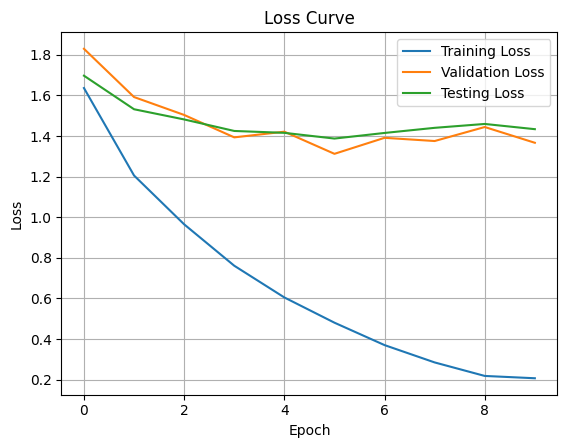

In [95]:
from matplotlib import pyplot as plt
plt.figure(figsize=[6.4, 4.8],facecolor='white', edgecolor='black',dpi=100)

plt.title('Loss Curve')
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.plot(test_loss,label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

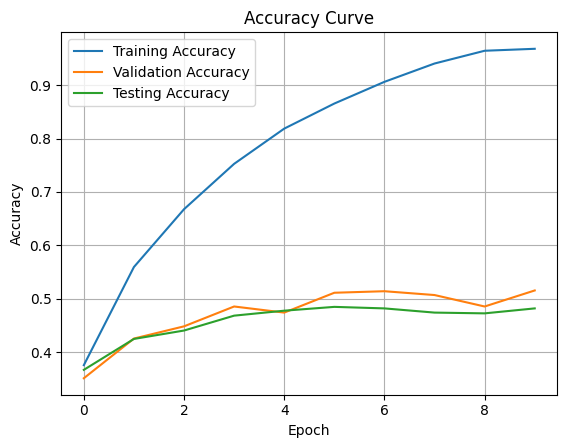

In [96]:
plt.figure(figsize=[6.4, 4.8],facecolor='white', edgecolor='black',dpi=100)
plt.title('Accuracy Curve')
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.plot(test_acc,label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Testing The Model

In [97]:
test_loop(test_dataloader, model, criterion)

Validation Loss: 1.3874 Acc: 0.4850


(1.3873678479875837, tensor(0.4850, device='cuda:0', dtype=torch.float64))